SABR model, stochastic $\alpha$, $\beta$, $\rho$:
$$
\begin{aligned}
    &dF_t = \alpha_t F_t^{\beta} dW_t^1 \\
    &d\alpha_t = \nu \alpha_t dW_t^2 \\
    & dW_t^1 dW_t^2 = \rho dt
\end{aligned}
$$
$\alpha_t$ is geometrical brownian motion, so we have:
$$
\alpha_t = \alpha_0 \exp( -0.5 \nu^2 t + \nu W_t^2 )
$$
It is natural to introduce new variable $y_t$ as:
$$
y_t = \ln \alpha_t.
$$ For $y_t$ we have the following SDE:
$$
d y_t = -0.5 \nu^2 dt + \nu
dW_t^2
$$

Let us consider the following change of variable for $F_t$:
$$
X_t = F_t^{-\beta+1}
$$Then:
$$
dX_t = (-\beta + 1) F_t^{-\beta} dF_t + 0.5 (-\beta+1) (-\beta) F_t^{-\beta-1} (dF_t)^2 = 
    (-\beta + 1)\alpha_t dW_t^1 + \alpha_t^2 \dfrac{\beta (\beta - 1)}{2 X_t}dt
$$

Another intresting choise is:
$$
X_t = \log \left( {F_t} \right) 
$$

$$
dX_t = \dfrac{dF_t}{F_t} - \dfrac{1}{2}\dfrac{(dF_t)^2}{F_t^2} = \alpha_t F_t^{\beta - 1} dW_t^1 - \dfrac{1}{2}\alpha_t^2 F_t^{2(\beta - 1)}dt = 
\alpha_t \exp(X_t (\beta - 1)) dW_t^1 - \dfrac{1}{2}\alpha_t^2 \exp(2 X_t (\beta - 1))dt
$$

Consider $X_t \to (\beta - 1) X_t$:
$$
dX_t = (\beta-1) \alpha_t \exp(X_t) dW_t^1 - \dfrac{(\beta-1)\alpha_t^2}{2} \exp(2 X_t)dt
= (\beta-1)\exp(y_t + X_t) dW_t^1 - \dfrac{(\beta-1)}{2} \exp(2 (X_t+y_t))dt
$$

So, for the price $V(x, y, t)$ of an option with payoff function $g(F_T)$, in the first case $x=F^{-\beta+1}$ we have following PDE:
$$
    V_t + e^{2 y} \dfrac{\beta (\beta - 1)}{2 x} V_x - \dfrac{\nu^2}{2} V_y + \dfrac{(-\beta + 1)^2}{2}e^{2y} V_{xx}
    + \dfrac{\nu^2}{2} V_{yy} + \nu \rho (-\beta + 1) e^{2y} V_{xy} = rV
$$

$$
\begin{aligned}
    &\mu_x = e^{2 y} \dfrac{\beta (\beta - 1)}{2 x}\\
    &\mu_y =  - \dfrac{\nu^2}{2}\\
    &\sigma_x = \dfrac{(-\beta + 1)^2}{2}e^{2y} \\
    &\sigma_y =  \dfrac{\nu^2}{2} V_{yy}\
    &\sigma_{xy} = \nu \rho (-\beta + 1) e^{2y}
\end{aligned}
$$
In the second case $x = (\beta-1) F$:

$$
    V_t - \dfrac{(\beta-1) e^{2(x+y)}}{2}V_x - \dfrac{\nu^2}{2} V_y + \dfrac{(\beta - 1)^2}{2}e^{2y+2x} V_{xx}
    + \dfrac{\nu^2}{2} V_{yy} + \nu \rho (-\beta + 1) e^{2(x+y)} V_{xy} = rV
$$

In [1]:
import sys
sys.path.append('../heston')

In [2]:
from montecarlo import *
from montecarlo_onestep import *
from heston import *
from solver import *

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

from sabr_approx import *

In [4]:
Npaths = 100000
Nt = 100

In [5]:
F0 = 1

beta = 0.25

rho = 0.25

r = 0.0

T = 0.5

alpha = 0.15
sig0 = 0.3

tn = T * np.linspace(0, 1, Nt)

In [6]:
F = SabrEulerModified(F0, sig0, Npaths, tn, alpha, beta, rho)

In [7]:
K = np.linspace(0.1 * F0, 2.0 * F0, 101)

In [8]:
payoff = np.maximum(F.reshape(-1, 1) - K.reshape(1, -1), 0.0)

In [9]:
C = np.mean(payoff, axis=0)

In [10]:
Cpetr, IVpetr = SabrApprox(K, F0, r, tn[-1], sig0, alpha, beta, rho)

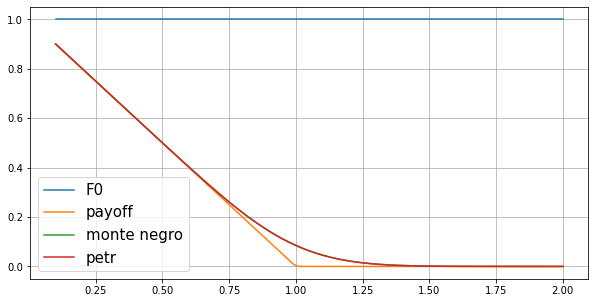

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(K, F0 * np.ones((len(K), 1)), label='F0')
plt.plot(K, np.maximum(F0 - K, 0.0), label='payoff')
plt.plot(K, C, label='monte negro')
plt.plot(K, Cpetr, label='petr')
plt.legend(fontsize=15)
plt.grid()

In [64]:
IVmonte = GetIv(C, K, F0, r, T)

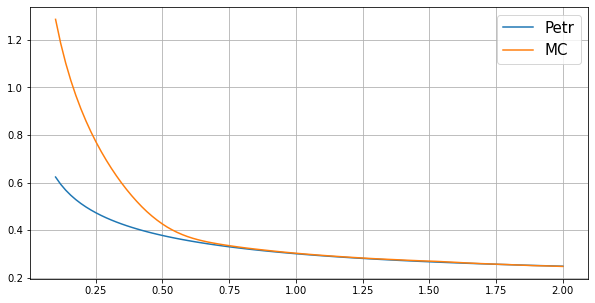

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(K, IVpetr, label='Petr')
plt.plot(K, IVmonte, label='MC')
plt.legend(fontsize=15)
plt.grid()

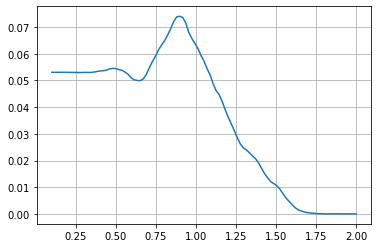

In [66]:
plt.plot(K, np.abs(C - Cpetr) / np.max(np.abs(C)) * 100)
plt.grid()

In [67]:
Fmax = 15 * F0
Fmin = 0.05 * F0

In [68]:
Nx = 100
Ny = 20
Nt = 30

In [69]:
def SolvePDE(k, Nx, Ny, Nt, alpha, beta, rho, F0, sig0, Fmin, Fmax):
    Fmin = 0.1 * k
    Fmax = 10 * k
    
    fctr = 5.0
    
    Fmin = F0 / fctr
    Fmax = F0 * fctr
    def gridX(Nx):
        tn = np.linspace(-1, 1, Nx + 1) ** 3
        
        Fn = F0 * np.exp(tn * np.log(fctr))
        
        xn = (Fn / k) ** (1 - beta) / (1 - beta)
        hx = np.diff(xn)
        return xn, hx

    def gridY(Ny):
        yn = np.linspace(-5, 5, Ny + 1)
        hy = np.diff(yn)
        return yn, hy

    def gridT(Nt):
        return T * np.linspace(0, 1.0, Nt + 1) ** 2
    
    
    Xleft = Neuman(lambda x: 0.0)

    Xright = Dirichle(lambda x: Fmax/k - 1)

    Yleft = Neuman(lambda x: 0.0)

    Yright = Neuman(lambda x: 0.0)

    boundary = Boundary2D(Xleft, Xright, Yleft, Yright)

    init = lambda x, y: np.maximum(0, ((1-beta) * x) ** (1 / (1-beta)) - 1.0)

    mux = lambda x, y: -sig0 ** 2 * np.exp(2 * alpha * y) / (2 * beta * (1-beta) * x * k ** (2 * (1-beta))) 
    muy = lambda x, y: -alpha/2

    sigmax = lambda x, y: sig0 ** 2 * np.exp(2 * alpha * y) / (2 * k ** (2 * (1-beta)))
    sigmay = lambda x, y: 0.5
    sigmaxy = lambda x, y: rho * sig0 * np.exp(alpha * y) / k ** (1-beta)

    problem = Problem(boundary, init, mux, muy, sigmax, sigmay, sigmaxy)

    der = DerFwdXY()
    
    xn, _ = gridX(Nx)

    Fn = (xn * (1-beta)) ** (1 / (1 - beta)) * k
    
    solverHV = ADI_CS(problem, der, gridX, gridY, gridT)
    uHV = solverHV.solve(Nx, Ny, Nt)
    
    C_finite = uHV[-1, :, Ny // 2] * k
    
    return C_finite, Fn

In [70]:
K = np.linspace(0.5 * F0, 2 * F0, 57)

Cpetr, IVpetr = SabrApprox(K, F0, r, tn[-1], sig0, alpha, beta, rho)

In [71]:
C = np.zeros_like(K)
for j, k in enumerate(K):
    c, F = SolvePDE(k, Nx, Ny, Nt, alpha, beta, rho, F0, sig0, Fmin, Fmax)
    i = np.argmin(np.abs(F - F0))
    C[j] = (c[i] + c[i - 1] + c[i + 1]) / 3

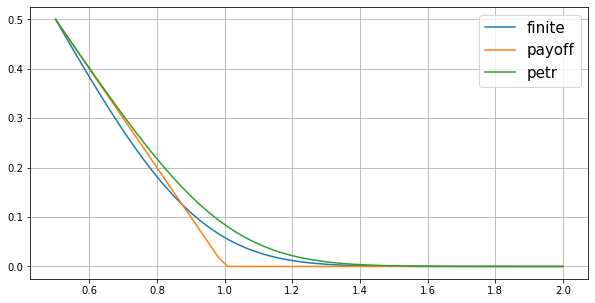

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(K, C / C[0] * Cpetr[0],  label='finite')
plt.plot(K, np.maximum(0, F0 - K), label='payoff')
plt.plot(K, Cpetr,  label='petr')
plt.legend(fontsize=15)
plt.grid()

In [73]:
IVFinite = GetIv(C / C[0] * Cpetr[0], K, F0, r, T)

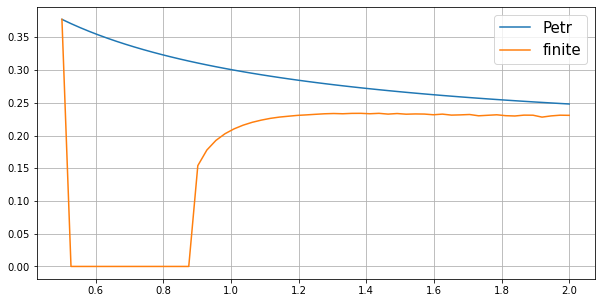

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(K, IVpetr, label='Petr')
plt.plot(K, IVFinite, label='finite')
plt.legend(fontsize=15)
plt.grid()